[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Deep_Learning_Finanzas/blob/main/Semana01/PINN.ipynb)

# Módulos

In [ ]:
from io import IncrementalNewlineDecoder
import torch
import torch.autograd as tgrad
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd
%matplotlib inline

In [ ]:
torch.cuda.is_available()

False

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_device(DEVICE)

# Drive del profesor

https://drive.google.com/drive/folders/1I5_eLRgLBdJyVRNWBFEJIMs1S15aZoQF?usp=drive_link


# Cargando su drive a colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Como funciona autograd

In [ ]:
tsr = torch.Tensor([1,2,4])

In [ ]:
tsr

tensor([1., 2., 4.])

In [ ]:
t1 = torch.rand((3,3), requires_grad=True)

In [ ]:
w1 = torch.randn((3,3), requires_grad = True)

In [ ]:
fn = w1*t1
print(fn.grad_fn)

In [ ]:
print(t1.grad_fn)

None


### Analytical solution

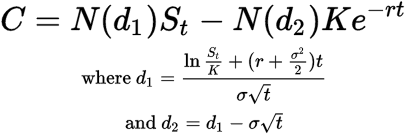

Datos sintéticos para probar el método

In [ ]:
S = torch.Tensor([80]).requires_grad_()
t = torch.Tensor([0]).requires_grad_()
sigma = torch.Tensor([0.3]).requires_grad_()
r = torch.Tensor([0.05]).requires_grad_()
K = torch.Tensor([70])
T = torch.Tensor([1])
t2m = T-t

d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * t2m)/(sigma * torch.sqrt(t2m))
d2 = d1 - sigma * torch.sqrt(t2m)

In [ ]:
N0 = lambda value: 0.5 * (1 + torch.erf((value/2**0.5))) #normal cdf
Nd1 = N0(d1)
Nd2 = N0(d2)
C = S* Nd1 - K* Nd2 *torch.exp(-r*t2m)
print("Precio de la opción:", C.item())

Precio de la opción: 17.01496124267578


### Ecuación Diferencial

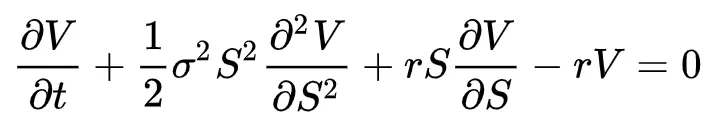

In [ ]:
dCdt = tgrad.grad(C, t, create_graph=True, only_inputs=True)[0]
dCdt

tensor([-5.8385], grad_fn=<NegBackward0>)

In [ ]:
dCdS = tgrad.grad(C, S, create_graph=True, only_inputs=True)[0]
d2CdS2 = tgrad.grad(dCdS, S, create_graph=True, only_inputs=True)[0]
dCdvol = tgrad.grad(C, sigma, create_graph=True, only_inputs=True)[0]

In [ ]:
print(f'Derivada con respecto S: {dCdS}')
print(f'Segunda derivada con respecto S: {d2CdS2}')
print(f'Derivada con respecto a la volatilidad: {dCdvol}')

Derivada con respecto S: tensor([0.7769], grad_fn=<AddBackward0>)
Segunda derivada con respecto S: tensor([0.0124], grad_fn=<AddBackward0>)
Derivada con respecto a la volatilidad: tensor([23.8776], grad_fn=<AddBackward0>)


In [ ]:
dCdt.item() + ((0.5*sigma**2) * (S**2)*d2CdS2.item() )+ r*S*dCdS.item() - r*C

tensor([0.], grad_fn=<SubBackward0>)

### PDE para modelado de opción Europea

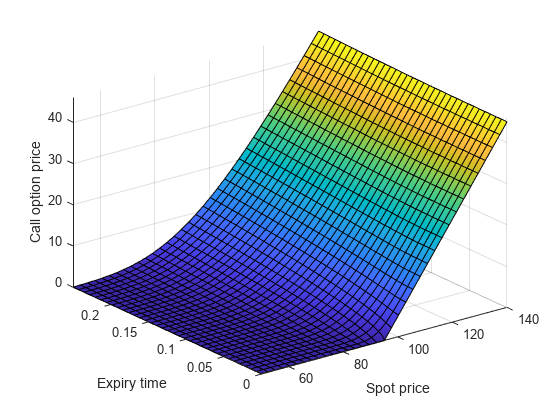

In [ ]:
K = 40
r = 0.05
sigma = 0.15
T = 1
S_range = [0, 160]
t_range = [0, T]
gs = lambda x: np.fmax(x-K, 0)

## Simulador de datos de entrada para  t y S

In [ ]:
def get_diff_data(n):
    X = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        np.random.uniform(*S_range, (n, 1))], axis=1)
    y = np.zeros((n, 1)) #price
    return X, y

# get_diff_data(10)

## Muestreo de datos que cumplen las condiciones iniciales

In [ ]:
def get_ivp_data(n):
    X = np.concatenate([np.ones((n, 1)), #all at expiry time
                    np.random.uniform(*S_range, (n, 1))], axis=1)
    y = gs(X[:, 1]).reshape(-1, 1)

    return X, y

# get_ivp_data(10)

## Muestreo de datos que cumplen las condiciones de frontera

In [ ]:
def get_bvp_data(n):
    X1 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        S_range[0] * np.ones((n, 1))], axis=1)
    y1 = np.zeros((n, 1))

    X2 = np.concatenate([np.random.uniform(*t_range, (n, 1)),
                        S_range[-1] * np.ones((n, 1))], axis=1)
    y2 = (S_range[-1] - K*np.exp(-r*(T-X2[:, 0].reshape(-1)))).reshape(-1, 1)

    return X1, y1, X2, y2



* BVP 1 $S = S_{min}$: 0

* BVP2 ($S = S_{max}$): $S_{max} - K \cdot e^{-rt}$

* IVP (t=T): $max(S-K,0)$ *call this initial but corresponds to expiry*

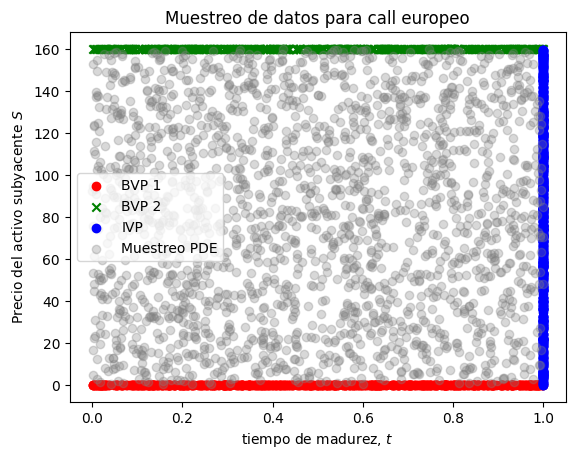

In [ ]:
bvp_x1,bvp_y1,bvp_x2,bvp_y2 = get_bvp_data(500)
ivp_x1,ivp_y1 = get_ivp_data(500)
diff_x1,diff_y1 = get_diff_data(2000)
plt.scatter(bvp_x1[:,0],bvp_x1[:,1], label= "BVP 1", color = "red",marker="o")
plt.scatter(bvp_x2[:,0],bvp_x2[:,1], label= "BVP 2", color = "green",marker="x")
plt.scatter(ivp_x1[:,0],ivp_x1[:,1], label= "IVP", color = "blue")
plt.scatter(diff_x1[:,0],diff_x1[:,1], label= "Muestreo PDE", color = "grey", alpha = 0.3)
plt.xlabel("tiempo de madurez, $t$")
plt.ylabel("Precio del activo subyacente $S$")
plt.title("Muestreo de datos para call europeo")
plt.legend()

# Simulación con una red neuronal informada por física (PINN)

In [ ]:
class european_call(nn.Module):
    "Define la red que tiene información de física"
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation1 = nn.LeakyReLU(negative_slope=0.1)
        activation2 = nn.Tanh()
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation1])
        self.fch = nn.Sequential(*[nn.Sequential(*[
                            nn.BatchNorm1d(N_HIDDEN),
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation1]) for _ in range(N_LAYERS)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

### declare model

In [ ]:
model = european_call(2,1,100,8)
optimizer = torch.optim.Adam(model.parameters(),lr=7e-5)
print (f"Model parameters : {sum(p.numel() for p in model.parameters())/10**3:.2f}K")

Model parameters : 82.80K


In [ ]:
print (model)

european_call(
  (fcs): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.1)
  )
  (fch): Sequential(
    (0): Sequential(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=100, out_features=100, bias=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=100, out_features=100, bias=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=100, out_features=100, bias=True)
      (2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (0): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Linear(in_features=100, out_features=100, bi

In [ ]:
N_sample = 500
physics_lr = 1000

loss_history={
    "total_loss":[],"loss1":[],"loss2":[],\
    "loss_bvp1":[],"loss_bvp2":[],"loss_ivp":[],
}

for i in range(1):
    optimizer.zero_grad()

    # Datos IVP
    ivp_x, ivp_y = get_ivp_data(N_sample)
    ivp_x_tensor = torch.from_numpy(ivp_x).float()
    ivp_y_tensor = torch.from_numpy(ivp_y).float()
    ivp_y_pred = model(ivp_x_tensor)
    mse_ivp = nn.MSELoss()(ivp_y_tensor, ivp_y_pred)

    # GDatos BVP
    bvp_x1, bvp_y1, bvp_x2, bvp_y2 = get_bvp_data(N_sample)
    bvp_x1_tensor = torch.from_numpy(bvp_x1).float()
    bvp_y1_tensor = torch.from_numpy(bvp_y1).float()
    bvp_x2_tensor = torch.from_numpy(bvp_x2).float()
    bvp_y2_tensor = torch.from_numpy(bvp_y2).float()
    bvp_y1_pred = model(bvp_x1_tensor)
    mse_bvp1 = nn.MSELoss()(bvp_y1_tensor, bvp_y1_pred)
    bvp_y2_pred = model(bvp_x2_tensor)
    mse_bvp2 = nn.MSELoss()(bvp_y2_tensor, bvp_y1_pred)

    # Juntar las "data loss"
    loss1 = mse_ivp + mse_bvp1 + mse_bvp2

    # Compute the "Black-Scholes loss"
    X1, y1 = get_diff_data(4*N_sample)
    X1 = torch.from_numpy(X1).float().requires_grad_()
    y1 = torch.from_numpy(y1).float()
    y1_hat = model(X1)
    grads = torch.autograd.grad(y1_hat, X1, grad_outputs=torch.ones(y1_hat.shape), retain_graph=True, create_graph=True, only_inputs=True)[0]
    dVdt, dVdS = grads[:, 0].view(-1, 1), grads[:, 1].view(-1, 1)
    grads2nd = torch.autograd.grad(dVdS, X1, grad_outputs=torch.ones(dVdS.shape), create_graph=True, only_inputs=True)[0]
    d2VdS2 = grads2nd[:, 1].view(-1, 1)
    S1 = X1[:, 1].view(-1, 1)
    bs_pde = dVdt + 0.5 * ((sigma * S1) ** 2) * d2VdS2 + r * S1 * dVdS - r * y1_hat
    loss2 = physics_lr * nn.MSELoss()(bs_pde, torch.zeros_like(bs_pde))

    # Backpropagate joint loss
    loss = loss1 + loss2
    loss_history["total_loss"].append(loss.item())
    loss_history["loss1"].append(loss1.item())
    loss_history["loss2"].append(loss2.item())
    loss_history["loss_ivp"].append(mse_ivp.item())
    loss_history["loss_bvp1"].append(mse_bvp1.item())
    loss_history["loss_bvp2"].append(mse_bvp2.item())
    loss.backward()
    optimizer.step()


    # Mostrar resultados conforme avanza el entrenamiento
    if (i + 1) % 500 == 0:
        print(f"Época {i+1}, Pérdida: {loss.item():.6f}")


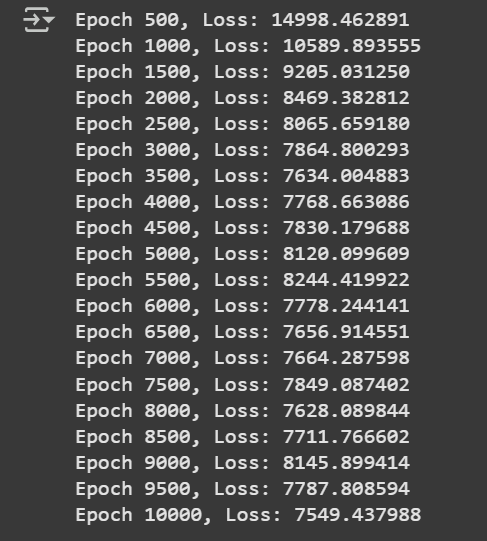

In [ ]:
loss_df = pd.DataFrame.from_dict(loss_history)
# loss_df["loss"] = loss_history
# loss_df["ma_100_loss"] = loss_df["loss"].rolling(100).mean()
# ax = loss_df.plot(y='loss', logy=True)
# loss_df.plot(y='ma_100_loss', ax=ax)
# ax.set_ylabel("Log loss")

In [ ]:
loss_df.head()

In [ ]:
#torch.save(model.state_dict(), "/content/drive/MyDrive/Curso-DeepLearning/Semana1/european_call_weights.pth")
#loss_df.to_csv("/content/drive/MyDrive/Curso-DeepLearning/Semana1/perdidas.csv")

In [ ]:
model = european_call(2,1,100,8)
model.load_state_dict(torch.load("/content/drive/MyDrive/Curso-DeepLearning/Semana1/european_call_weights.pth"))

<ipython-input-28-c394c3b7768e>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/content/drive/MyDrive/Curso-DeepLearning/Semana1/european

<All keys matched successfully>

In [ ]:
loss_df = pd.read_csv("/content/drive/MyDrive/Curso-DeepLearning/Semana1/perdidas.csv", index_col='Unnamed: 0')

In [ ]:
loss_df

,total_loss,loss1,loss2,loss_bvp1,loss_bvp2,loss_ivp
0,18707.902344,17877.246094,830.656128,0.095459,14625.548828,3251.601074
1,18811.718750,18164.175781,647.542542,0.094042,14624.873047,3539.208740
2,18693.033203,18143.250000,549.782288,0.102298,14622.651367,3520.496094
3,18676.765625,18202.312500,474.453217,0.107815,14620.649414,3581.554932
4,18752.814453,18303.326172,449.487335,0.110334,14617.975586,3685.240234
...,...,...,...,...,...,...
9995,7534.099609,7371.793945,162.305511,3579.241943,3745.686523,46.865143
9996,7584.211914,7390.431152,193.780807,3686.872559,3639.707520,63.850975
9997,7546.565430,7407.644531,138.920929,3745.799072,3584.341797,77.503571
9998,7509.814453,7356.410156,153.404510,3629.228516,3693.123779,34.057625


In [ ]:
loss_df.tail(100).mean()

,0
total_loss,7639.141543
loss1,7407.659033
loss2,231.482524
loss_bvp1,3661.847109
loss_bvp2,3666.142791
loss_ivp,79.669142


Text(0.5, 1.0, 'Pérdida total en entrenamiento')

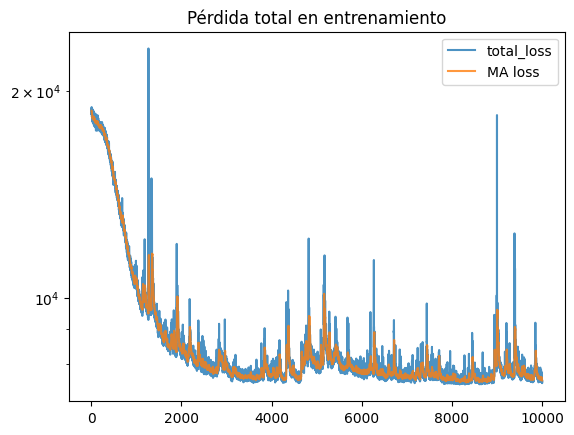

In [ ]:
ax = loss_df[["total_loss"]].plot(logy=True,alpha=0.8)
loss_df[["total_loss"]].rename(columns={"total_loss":"MA loss"}).rolling(10).mean().plot(logy=True,alpha=0.8, label="MA", ax = ax)
plt.title("Pérdida total en entrenamiento")

Text(0.5, 1.0, 'Curva del entrenamiento, media móvil de las pérdidas')

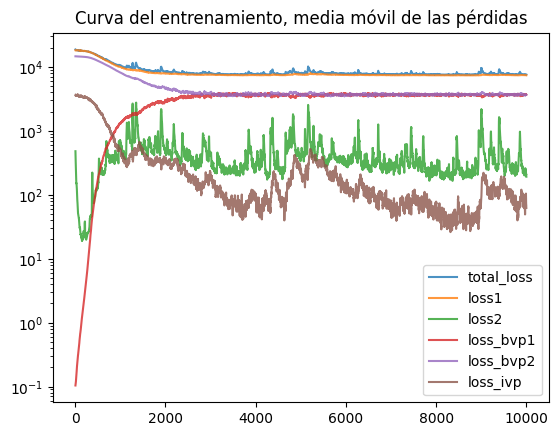

In [ ]:
loss_df.rolling(10).mean().plot(logy=True,alpha=0.8)
plt.title("Curva del entrenamiento, media móvil de las pérdidas")

<Axes: >

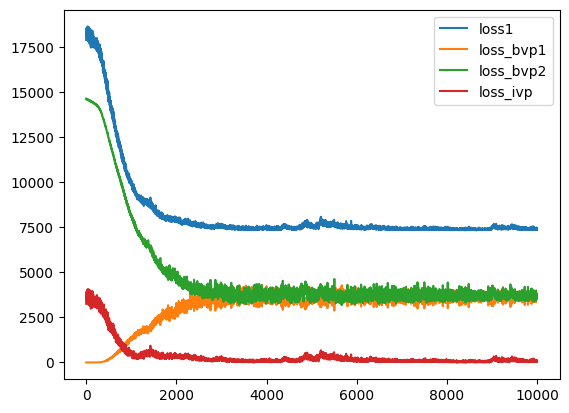

In [ ]:
loss_df[["loss1","loss_bvp1","loss_bvp2","loss_ivp"]].plot()

### Evaluación

In [ ]:
def eur_call_analytical_price(S, t, K, sigma):
    t2m = t  # Tiempo de madurez (en años)
    d1 = (torch.log(S / K) + (r + 0.5 * sigma**2) * t2m) / (sigma * torch.sqrt(t2m))
    d2 = d1 - sigma * torch.sqrt(t2m)
    # Función de distribución acumulada de la normal (CDF)
    N0 = lambda value: 0.5 * (1 + torch.erf(value / (2**0.5)))
    Nd1 = N0(d1)
    Nd2 = N0(d2)
    # Calculo del precio de la opción
    C = S * Nd1 - K * Nd2 * torch.exp(-r * t2m)
    return C

In [ ]:
eur_call_analytical_price(torch.tensor([80]),torch.tensor([1]),torch.tensor([70]), sigma =0.30)

tensor([17.0150])

In [ ]:
s = np.linspace(S_range[0], S_range[1], 50)
t = np.linspace(t_range[0], t_range[1], 50)
s_grid, t_grid = np.meshgrid(s, t)

s_flat = s_grid.flatten()
t_flat = t_grid.flatten()

# Crea un tensor 2D de los arreglos
X_test = torch.tensor(np.column_stack((t_flat, s_flat)), dtype=torch.float)

y_analytical_test = eur_call_analytical_price(X_test[:,1],X_test[:,0],torch.tensor([K]), sigma = sigma)
X_test.shape,y_analytical_test.shape

(torch.Size([2500, 2]), torch.Size([2500]))

In [ ]:
with torch.no_grad():
  y_pinn_test = model(X_test)

Text(0.5, 1.0, 'Valuación de Call Europeo')

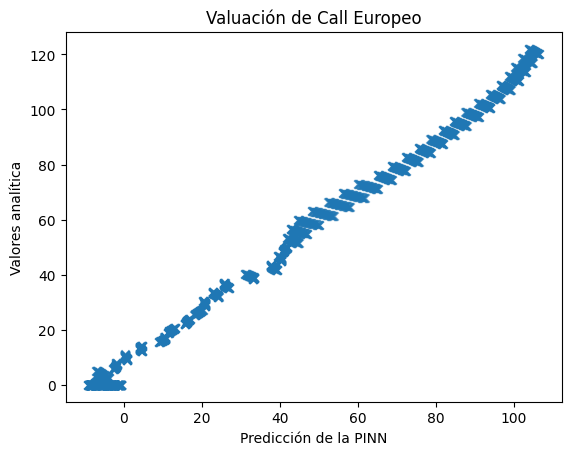

In [ ]:
plt.scatter(x= y_pinn_test.detach().numpy(), y = y_analytical_test.detach().numpy(), marker = "x", alpha = 0.5)
plt.xlabel("Predicción de la PINN")
plt.ylabel("Valores analítica")
plt.title("Valuación de Call Europeo")

In [ ]:
y_pinn_test.detach().numpy().shape

(2500, 1)

In [ ]:
np.corrcoef(y_pinn_test.detach().numpy().reshape(y_pinn_test.shape[0],),y_analytical_test.detach().numpy())

array([[1.        , 0.99803642],
       [0.99803642, 1.        ]])

In [ ]:
%matplotlib inline

In [ ]:
# y_analytical_test.detach().numpy().shape

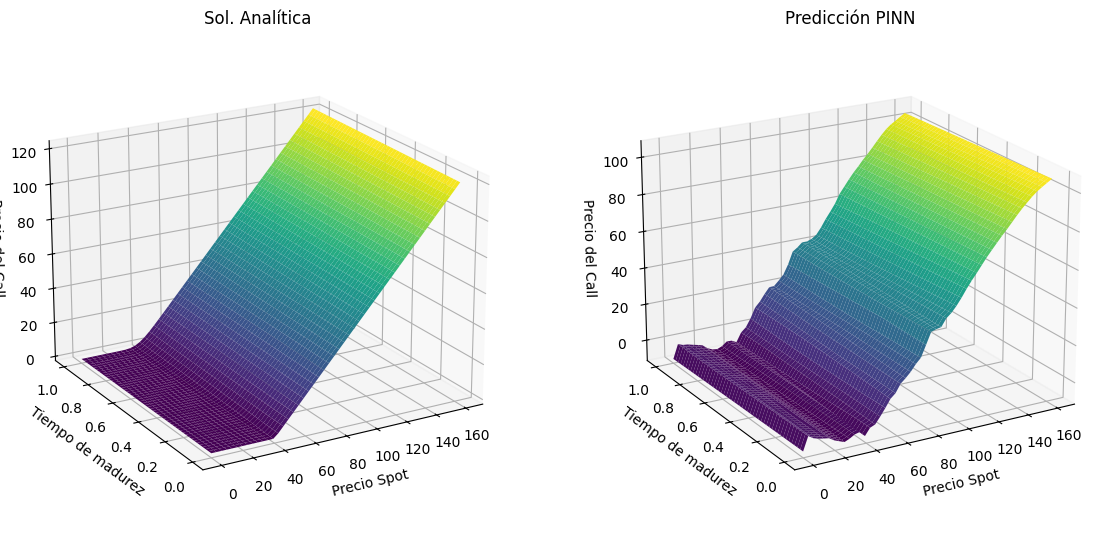

In [ ]:
# Create the 3D plot
fig = plt.figure(figsize=(14,7))
ax = fig.add_subplot(121, projection='3d')
ax.plot_surface(s_grid, t_grid, y_analytical_test.detach().numpy().reshape(s_grid.shape), cmap = "viridis")
ax.set_title("Sol. Analítica")
ax.set_xlabel("Precio Spot")
ax.set_ylabel("Tiempo de madurez")
ax.set_zlabel("Precio del Call")
ax.view_init(elev=20, azim=-120)

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(s_grid, t_grid, y_pinn_test.detach().numpy().reshape(s_grid.shape), cmap = "viridis")
ax.set_title("Predicción PINN")
ax.set_xlabel("Precio Spot")
ax.set_ylabel("Tiempo de madurez")
ax.set_zlabel("Precio del Call")
ax.view_init(elev=20, azim=-120)


torch.Size([50, 2]) torch.Size([50])


Text(0.5, 1.0, 'Analítica vs PINN, precio para t = 0.75')

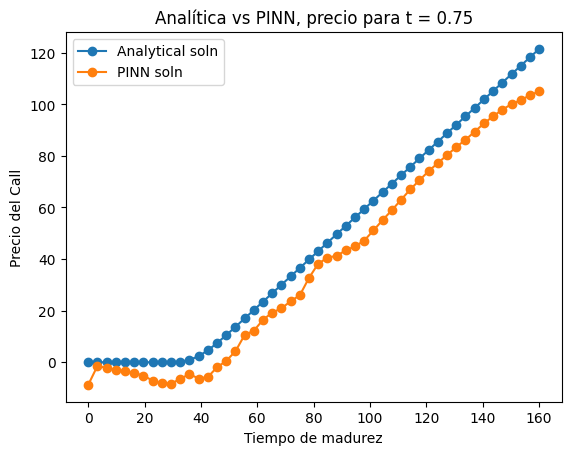

In [ ]:
s1 = np.linspace(S_range[0], S_range[1], 50)
t1 = np.array([0.75]*s1.shape[0])

# Crea tensores 2D de los arreglos
X_test1 = torch.tensor(np.column_stack((t1, s1)), dtype=torch.float)

y_analytical_test1 = eur_call_analytical_price(X_test1[:,1],X_test1[:,0],torch.tensor([K]), sigma = sigma)
print(X_test1.shape,y_analytical_test1.shape)

with torch.no_grad():
  y_pinn_test1a = model(X_test1)

plt.plot(s1, y_analytical_test1.detach().numpy(), marker='o', linestyle='-', label="Analytical soln")
plt.plot(s1, y_pinn_test1a.detach().numpy().reshape(s1.shape), marker='o', linestyle='-', label="PINN soln")
plt.xlabel('Tiempo de madurez')
plt.ylabel('Precio del Call')
plt.legend()
plt.title("Analítica vs PINN, precio para t = 0.75")

torch.Size([50, 2]) torch.Size([50])


Text(0.5, 1.0, 'Analítica vs PINN, precio para t = 0.25')

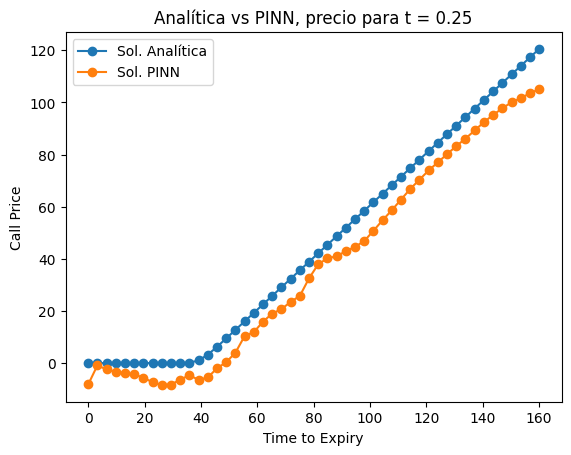

In [ ]:
s1 = np.linspace(S_range[0], S_range[1], 50)
t1 = np.array([0.25]*s1.shape[0])

# Crea tensor 2D de los arreglos
X_test1 = torch.tensor(np.column_stack((t1, s1)), dtype=torch.float)

y_analytical_test1 = eur_call_analytical_price(X_test1[:,1],X_test1[:,0],torch.tensor([K]), sigma = sigma)
print(X_test1.shape,y_analytical_test1.shape)

with torch.no_grad():
  y_pinn_test1a = model(X_test1)

plt.plot(s1, y_analytical_test1.detach().numpy(), marker='o', linestyle='-', label="Sol. Analítica")
plt.plot(s1, y_pinn_test1a.detach().numpy().reshape(s1.shape), marker='o', linestyle='-', label="Sol. PINN")
plt.xlabel('Time to Expiry')
plt.ylabel('Call Price')
plt.legend()
plt.title("Analítica vs PINN, precio para t = 0.25")

# Referencias
* https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb
* https://www.investopedia.com/terms/b/blackscholes.asp
* https://www.mathworks.com/help/symbolic/the-black-scholes-formula-for-call-option-price.html
* https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb
* https://medium.com/@andeyharsha15/deep-neural-networks-for-solving-differential-equations-in-finance-da662ef0681